<a href="https://colab.research.google.com/github/thanujTa/machine-learning-projects/blob/main/Food_101_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9756e5d1-a5c2-9284-e304-0a6043ec6a97)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-14 09:43:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-14 09:43:00 (41.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## Using Tensorflow Datasets of Food101 for this project

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# list all the available datasets in tensorflow datasets catalogue
d_list = tfds.list_builders()
d_list

In [ ]:
# Import and load in Food101 dataset
(train_data, test_data), ds_info  = tfds.load("food101",
                                               split=["train", "validation"],
                                               shuffle_files = True,# Shuffling the images in the datasets to make the model train on different patterns
                                               as_supervised = True,
                                               with_info = True)

## Exploring the dataset to get a bigger picture

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:30]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes']

In [ ]:
# Take a sample picture the training data
sample_data = train_data.take(1)
sample_data

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:


# info about the sample
for image, label in sample_data:
  print(f"""
  Image_shape = {image.shape},
  image_datatype = {image.dtype},
  class from the data: {label},
  class name :{class_names[label.numpy()]}
  """)


tf.reduce_min(image), tf.reduce_max(image)


  Image_shape = (512, 512, 3),
  image_datatype = <dtype: 'uint8'>,
  class from the data: 31,
  class name :donuts
  


(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'donuts')

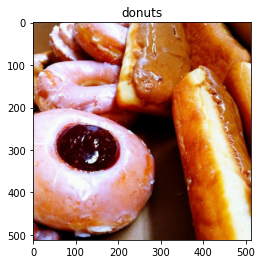

In [ ]:
# visualising the image
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])

## Creating functions to preprocess our data

In [ ]:
def preprocess_image(image, label, img_shape = 224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

## preparing batches for the data

### mapping the train, test data and turning them into batches

In [ ]:
train_data = train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

#mapping for test data
test_data = test_data.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
 

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

##Creating Callbacks

In [ ]:
# creating tensorboard callback
from helper_functions import create_tensorboard_callback
#create modelcheckpoint callback
checkpoint_path = "model_checkpoint/cp.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weight_only=True,
                                                      verbose =0)

## setting up Mixed Precision

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy

<function keras.mixed_precision.policy.global_policy>

##Building the Feature Extraction Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# creating a base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, outputs)

###Compiling the model

In [ ]:
model_1.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

###checking layer dtypes policies

In [ ]:
for layer in model_1.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

###Fitting the model with callbacks

In [ ]:
history_model_1 =model_1.fit(train_data,
                             epochs = 4,
                             steps_per_epoch = len(train_data),
                             validation_data = test_data,
                             validation_steps = int(0.25*len(test_data)),
                             callbacks=[create_tensorboard_callback(dir_name="logs_train",
                                                                    experiment_name = "food_101_feature_extraction"),
                                        model_checkpoint])

Saving TensorBoard log files to: logs_train/food_101_feature_extraction/20220414-103107
Epoch 1/4
2368/2368 [==============================] - ETA: 0s - loss: 1.8227 - accuracy: 0.5564INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


2368/2368 [==============================] - 222s 91ms/step - loss: 1.8227 - accuracy: 0.5564 - val_loss: 1.2411 - val_accuracy: 0.6753
Epoch 2/4
2368/2368 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.6663INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


2368/2368 [==============================] - 215s 90ms/step - loss: 1.2928 - accuracy: 0.6663 - val_loss: 1.1409 - val_accuracy: 0.6965
Epoch 3/4
2367/2368 [============================>.] - ETA: 0s - loss: 1.1442 - accuracy: 0.7039INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


2368/2368 [==============================] - 210s 88ms/step - loss: 1.1441 - accuracy: 0.7039 - val_loss: 1.0930 - val_accuracy: 0.7057
Epoch 4/4
2367/2368 [============================>.] - ETA: 0s - loss: 1.0456 - accuracy: 0.7261INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


INFO:tensorflow:Assets written to: model_checkpoint/cp.ckpt/assets


2368/2368 [==============================] - 213s 89ms/step - loss: 1.0456 - accuracy: 0.7261 - val_loss: 1.0647 - val_accuracy: 0.7116


In [ ]:
results_history_1= model_1.evaluate(test_data)

790/790 [==============================] - 51s 64ms/step - loss: 1.0667 - accuracy: 0.7122


### Results for the base model

* After fitting the base model we get a 'val_accuracy' of 71% which is not enough to beat the original food101 paper results. Hence we try to fine tune the model and restructure the model

In [ ]:
model_1_cloned = tf.keras.models.clone_model(model_1)
model_1_cloned.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
!ls model_checkpoint/

cp.ckpt


In [ ]:
checkpoint_path

'model_checkpoint/cp.ckpt'

In [ ]:
# Load the checkpoint weights to the cloned model
model_1_cloned.load_weights(checkpoint_path)

In [ ]:
# recompiling the cloned model with the same parameters as original
model_1_cloned.compile(loss = "sparse_categorical_crossentropy",
                       optimizer= tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [ ]:
# evaluating the cloned model with loaded weights 
results_cloned_model = model_1_cloned.evaluate(test_data)

790/790 [==============================] - 62s 74ms/step - loss: 1.7106 - accuracy: 0.5535


In [ ]:
for layer in model_1_cloned.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False 

In [ ]:
# saving the model to local instance
save_model_dir = "Feature_extraction_model_MP_EfficientnetB0"
model_1.save(save_model_dir)

INFO:tensorflow:Assets written to: Feature_extraction_model_MP_EfficientnetB0/assets


INFO:tensorflow:Assets written to: Feature_extraction_model_MP_EfficientnetB0/assets


In [ ]:
#loading our save model
load_saved_model_1 = tf.keras.models.load_model(save_model_dir)

In [ ]:
for layer in load_saved_model_1.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy )

In [ ]:
results_load_saved_model_1=load_saved_model_1.evaluate(test_data)

790/790 [==============================] - 63s 76ms/step - loss: 1.0667 - accuracy: 0.7122


In [ ]:
assert np.isclose(results_history_1, results_load_saved_model_1).all()

In [ ]:
load_saved_model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

### unfreezing the layers from model_1


In [ ]:
for layer in load_saved_model_1.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d_2 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in load_saved_model_1.layers[1].layers[:30]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_2 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "m

### creating callbacks

In [ ]:
# creating early stopping callbacks to stop the model to train if the validation loss is not improving after 4 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience= 4)

#creating modelcheckpoint callback to save best model during finetuning
checkpoint_path = "fine_tuning_model_checkpoints/"

model_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_best_only=True,
                                                       monitor = "Val_loss")

# creating ReduceLROnPlateau
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                             factor = 0.2,
                                             patience = 2,
                                             verbose =1,
                                             min_lr = 1e-7)

## Compiling and Fitting the fine tuned model with the callbacks

In [ ]:
# compiling the loaded model with 10x reduction of learning rate which by default it 0.001
load_saved_model_1.compile(loss = "sparse_categorical_crossentropy",
                           optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
                           metrics = ["accuracy"])

In [ ]:
history_load_saved_model = load_saved_model_1.fit(train_data,
                                                  epochs = 100,
                                                  steps_per_epoch =len(train_data),
                                                  validation_data = test_data,
                                                  validation_steps = int(0.25*len(test_data)),
                                                  callbacks = [create_tensorboard_callback("logs_train",
                                                                                           experiment_name = "fine_tuning_model_EfficientNetB0"),
                                                               model_checkpoint_1,
                                                               early_stopping,
                                                               lr_red])

Saving TensorBoard log files to: logs_train/fine_tuning_model_EfficientNetB0/20220414-121039
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9964WARNING:tensorflow:Can save best model only with Val_loss available, skipping.


2368/2368 [==============================] - 341s 143ms/step - loss: 0.0214 - accuracy: 0.9964 - val_loss: 1.1737 - val_accuracy: 0.7920 - lr: 2.0000e-05
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.0092 - accuracy: 0.9990WARNING:tensorflow:Can save best model only with Val_loss available, skipping.


2368/2368 [==============================] - 348s 146ms/step - loss: 0.0092 - accuracy: 0.9990 - val_loss: 1.3144 - val_accuracy: 0.7887 - lr: 2.0000e-05
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9996


Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 340s 143ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 1.4154 - val_accuracy: 0.7931 - lr: 2.0000e-05
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9999WARNING:tensorflow:Can save best model only with Val_loss available, skipping.


2368/2368 [==============================] - 339s 143ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 1.4754 - val_accuracy: 0.7944 - lr: 4.0000e-06
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9999WARNING:tensorflow:Can save best model only with Val_loss available, skipping.



Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
2368/2368 [==============================] - 337s 142ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 1.5587 - val_accuracy: 0.7963 - lr: 4.0000e-06


In [ ]:
results_load_saved_model_1= load_saved_model_1.evaluate(test_data)

213/790 [=======>......................] - ETA: 41s - loss: 1.5706 - accuracy: 0.7959